In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Analysis of Human brain spatial data

Data Analysis Outline

1.  Load data into Anndata

Preprocessing

2.1. Quality control

2.2. Feature selection

2.3. Normalization 

Feature Reduction and Visualization

3.1. Principal Component Analysis (PCA)

Downstream Analysis

4.1. Clustering

4.2. Visualization of data using UMAP and spatial structure 

4.3. Differential Expression Analysis

4.4. Marker Identification

4.5. Conclusion



In [2]:
!pip install scanpy
!pip install leidenalg
!pip install spatialde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 4.4 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8048 sha256=075396086f78f5a7a176b6175b08615e47e2c7d22a183237e7975f27829a5e1d
  Stored in directory: /root/.cache/pip/wheels/bd/ad/14/6a42359351a18337a8683854cfbba99dd782271f2d1767f87f
Successfully built session-info
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.6 MB/s eta 0:00:0000:010:01


In [3]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import leidenalg
import SpatialDE

In [4]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Brain_Section_1")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

  0%|          | 0.00/9.78M [00:00<?, ?B/s]

  0%|          | 0.00/18.1M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata

AnnData object with n_obs × n_vars = 4910 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

### 2.1 Quality Control

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

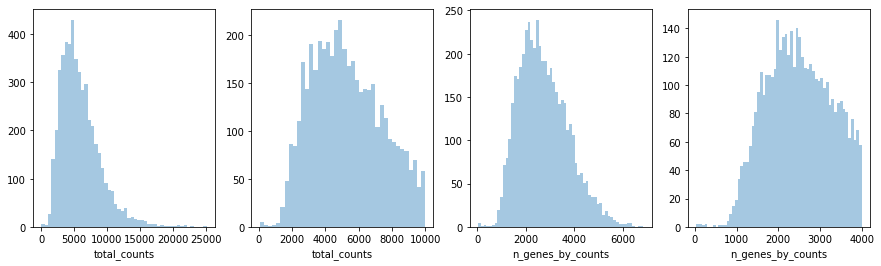

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [7]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
sc.pp.filter_genes(adata, min_cells=10)

/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


### 2.2 Normalization

In [8]:
# Normalize the adata 
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

### 2.3 Selecting highly varaible genes

In [9]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)

### 3.1. Principal Component Analysis (PCA)

In [10]:
sc.pp.pca(adata)


### 4.1. Clustering

In [11]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

### 4.2. Visualization using Uniform Manifold Approximation and Projection (UMAP) and in spatial structure 

... storing 'feature_types' as categorical
... storing 'genome' as categorical


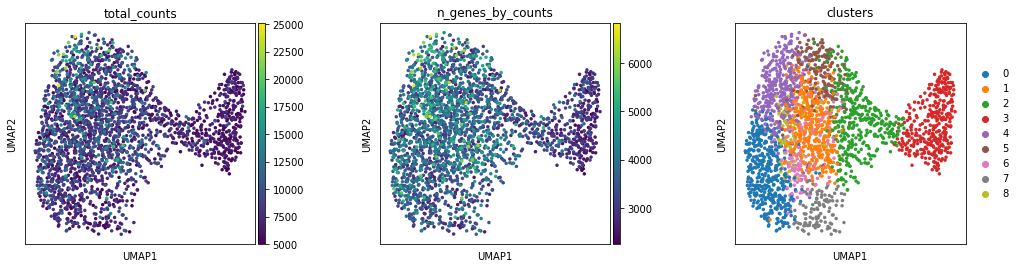

In [12]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

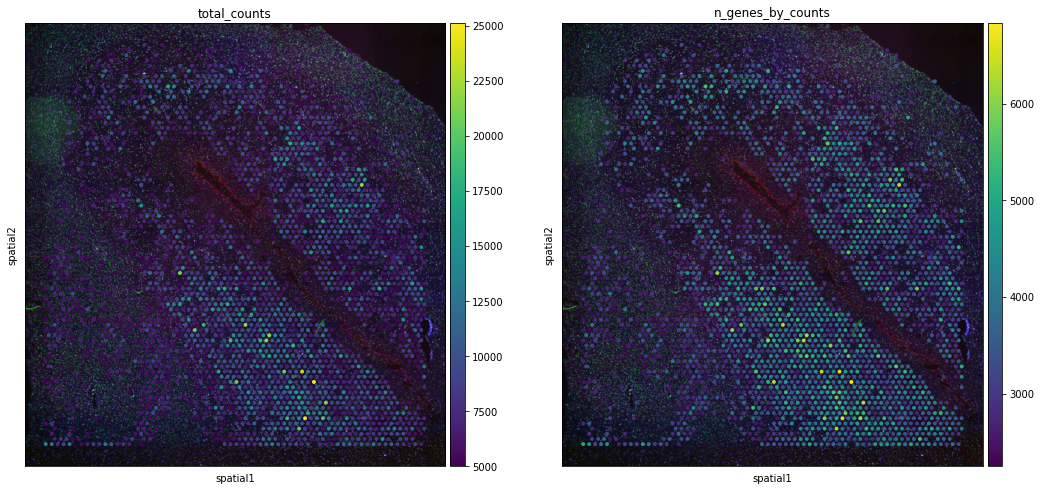

In [13]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

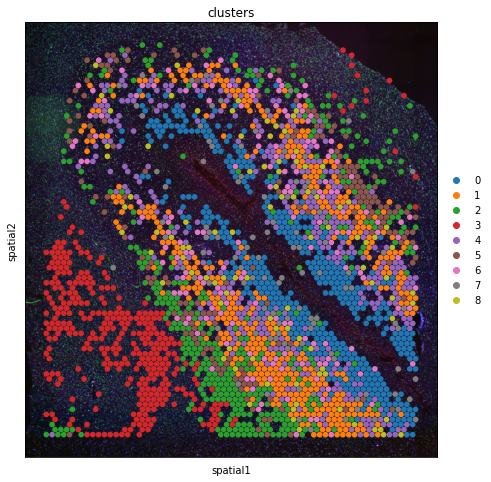

In [14]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)

### 4.3. Differential Expression Analysis

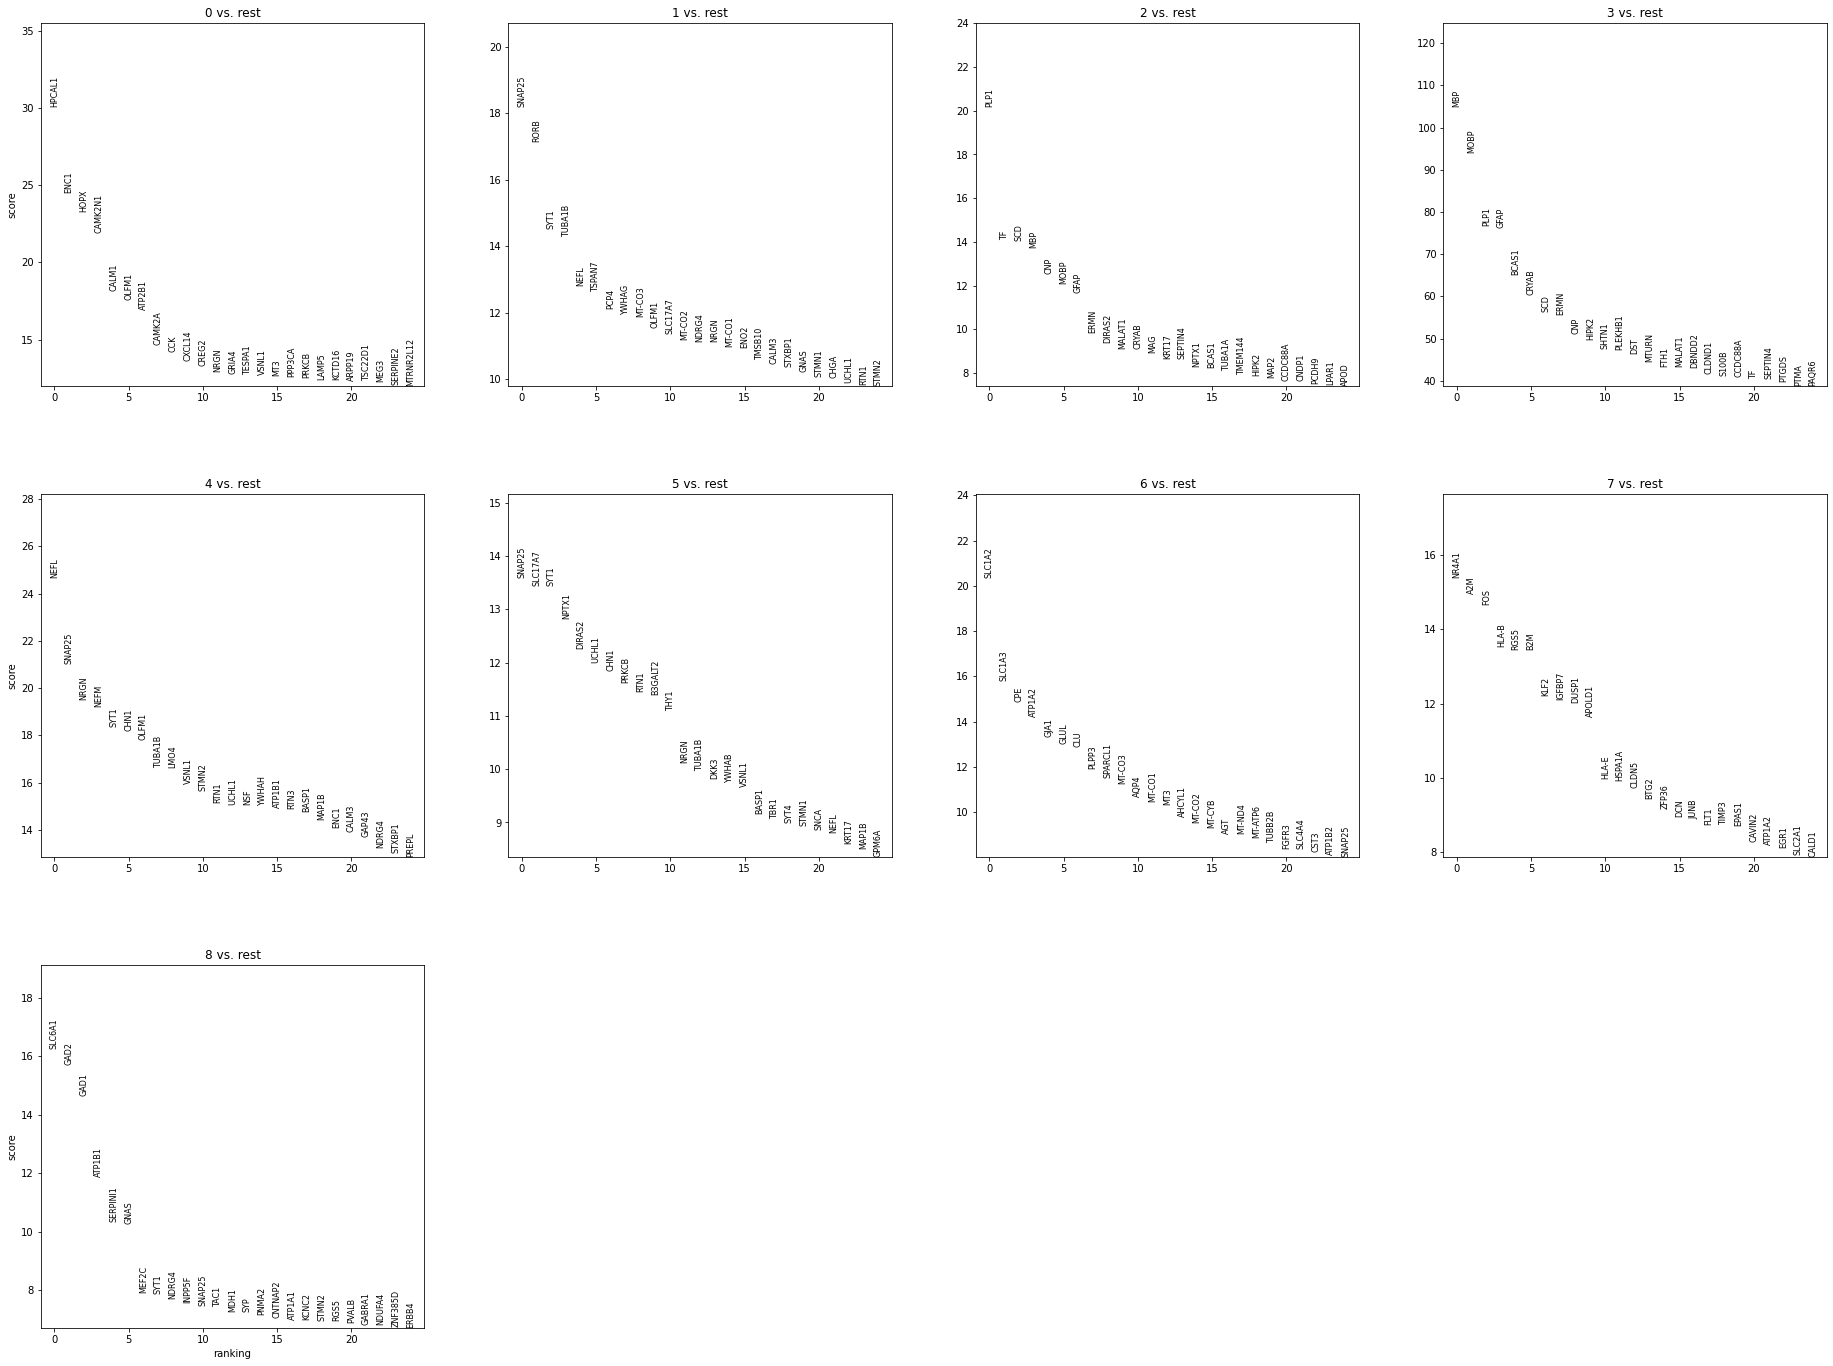

In [15]:
# Compute marker genes for cluster 0 and plot a heatmap with expression levels of its top 10 marker genes across clusters.
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [16]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p
0,HPCAL1,5.086801e-127,SNAP25,3.484351e-67,PLP1,1.399777e-74,MBP,0.000000e+00,NEFL,4.837628e-99,SNAP25,1.675771e-33,SLC1A2,3.062990e-52,NR4A1,1.034181e-29,SLC6A1,1.257160e-30
1,ENC1,2.114323e-102,RORB,5.253209e-54,TF,6.919410e-39,MOBP,0.000000e+00,SNAP25,9.921325e-83,SLC17A7,3.690875e-31,SLC1A3,4.265666e-37,A2M,1.527132e-28,GAD2,8.087222e-29
2,HOPX,2.011847e-89,SYT1,1.138133e-43,SCD,9.481270e-40,PLP1,0.000000e+00,NRGN,2.185894e-70,SYT1,1.715643e-32,CPE,8.016502e-35,FOS,2.892158e-28,GAD1,1.377159e-26
3,CAMK2N1,1.568191e-82,TUBA1B,5.799803e-42,MBP,1.053435e-38,GFAP,0.000000e+00,NEFM,1.111416e-61,NPTX1,1.690015e-28,ATP1A2,2.395791e-32,HLA-B,1.838772e-25,ATP1B1,2.190305e-21
4,CALM1,1.879782e-63,NEFL,3.684302e-35,CNP,2.530417e-32,BCAS1,3.803045e-263,SYT1,1.855801e-62,DIRAS2,3.499802e-26,GJA1,3.109790e-29,RGS5,2.567751e-25,SERPINI1,4.295743e-18
5,OLFM1,1.567639e-61,TSPAN7,5.794023e-34,MOBP,8.494535e-31,CRYAB,7.600565e-251,CHN1,2.473509e-63,UCHL1,6.940747e-27,GLUL,1.803820e-28,B2M,1.491588e-25,GNAS,8.319132e-18
6,ATP2B1,3.636568e-55,PCP4,5.406025e-30,GFAP,9.013873e-29,SCD,1.600973e-253,OLFM1,1.365610e-59,CHN1,1.821073e-26,CLU,3.804941e-28,KLF2,2.465903e-22,MEF2C,2.092930e-12
7,CAMK2A,2.555441e-43,YWHAG,9.982381e-31,ERMN,2.417724e-21,ERMN,2.704336e-213,TUBA1B,1.213044e-51,PRKCB,1.178882e-24,PLPP3,8.880229e-25,IGFBP7,4.467221e-22,SYT1,1.838702e-12
8,CCK,2.803999e-41,MT-CO3,3.230398e-30,DIRAS2,2.305841e-19,CNP,2.467139e-207,LMO4,3.222077e-51,RTN1,1.726670e-24,SPARCL1,6.182384e-24,DUSP1,5.931918e-22,NDRG4,6.080657e-12
9,CXCL14,1.011658e-36,OLFM1,4.572456e-29,MALAT1,1.037360e-18,HIPK2,4.363501e-206,VSNL1,1.563283e-49,B3GALT2,2.491402e-23,MT-CO3,1.744568e-23,APOLD1,5.343384e-21,INPP5F,1.319672e-11


### 4.4. Marker Identification 

categories: 0, 1, 2, etc.
var_group_labels: 0


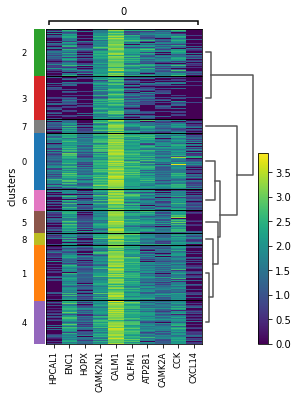

In [17]:
sc.pl.rank_genes_groups_heatmap(adata, groups="0", n_genes=10, groupby="clusters")

categories: 0, 1, 2, etc.
var_group_labels: 1


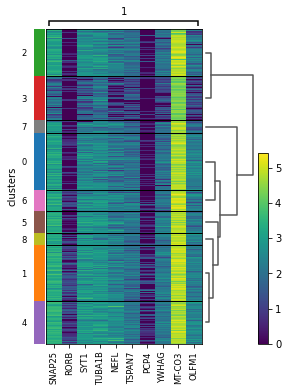

In [18]:
# Compute marker genes for cluster 1 and plot a heatmap with expression levels of its top 10 marker genes across clusters.
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="1", n_genes=10, groupby="clusters")

categories: 0, 1, 2, etc.
var_group_labels: 2


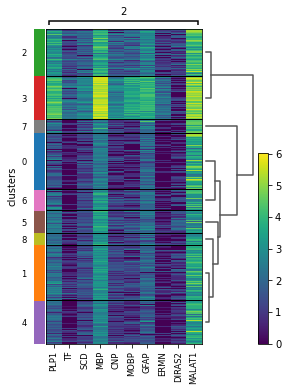

In [19]:
# Compute marker genes for cluster 2 and plot a heatmap with expression levels of its top 10 marker genes across clusters.
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="2", n_genes=10, groupby="clusters")

categories: 0, 1, 2, etc.
var_group_labels: 3


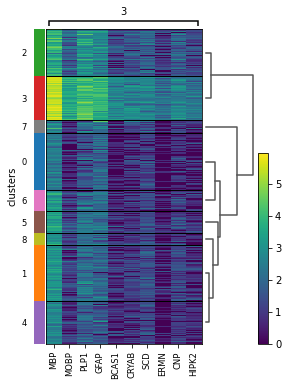

In [20]:
# Compute marker genes for cluster 3 and plot a heatmap with expression levels of its top 10 marker genes across clusters.
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="3", n_genes=10, groupby="clusters")

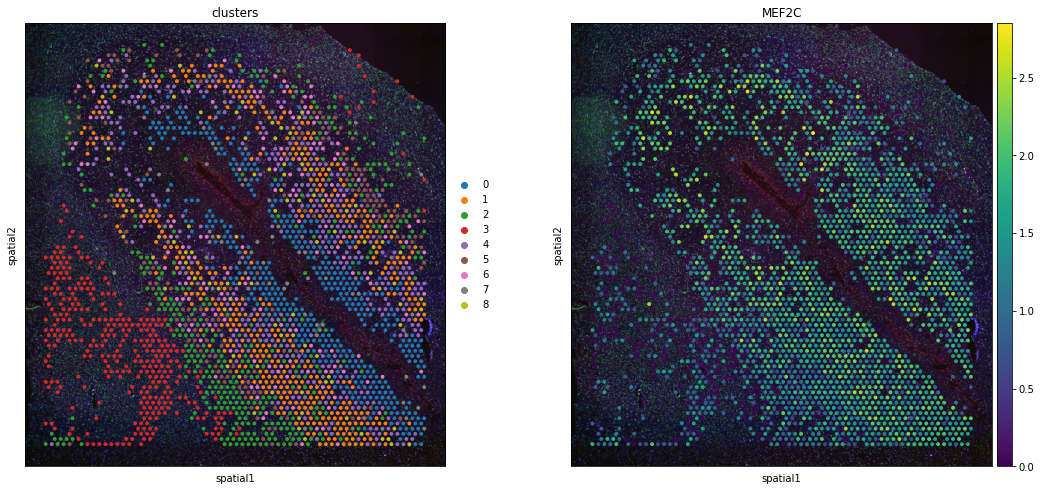

In [21]:
# Visualizing individual genes (For e.g. MEF2C gene) in the spatial structure. 
sc.pl.spatial(adata, img_key="hires", color=["clusters", "MEF2C"])

### Conclusion 

#### TOP 10 Marker genes

* Most of marker genes in Cluster 0 are Neurons & Oligodendrocytes and Photoreceptor cells. 
Top 10 marker genes: MEF2C, ENC1, NEFM, GABRB2, NEFL, GABRB1, HOPX, GABBR2, RGS4, SERPINI1

* Most of marker genes in Cluster 1 are Oligodendrocytes. 
Top 10 marker genes: MOBP, BCAS1, PLP1, ERMN, CRYAB, CNP, MBP, GFAP, SHTN1, HPK2


* Most of marker genes in Cluster 2 are Neurons & Oligodendrocytes. 
Top 10 marker genes: NEFL, SYT1, PRKCB, NEFM, MAP2, SLC17A7, CHN1, SNAP25, VSNL1, STMN2

* Most of marker genes in Cluster 3 are Cardiomyocytes.
Top 10 marker genes: SLC1A2, CPE, MT-ATP8, GLUL, NR4A1, SPARCL1, MT-ND4L, CXCL14, MTRNR2L8 


In [23]:
!pip install spatialde

  Preparing metadata (setup.py) ... done
  Created wheel for NaiveDE: filename=NaiveDE-1.2.0-py3-none-any.whl size=5712 sha256=3e555b328c9321dd10c3c07d390134bc490fe0f0738863cf1c8e074896c890a6
  Stored in directory: /root/.cache/pip/wheels/32/32/4d/28db4e878adcfff8255ae5745681cbb19cf2ea65a637a3e6b1
Successfully built NaiveDE


In [26]:
import SpatialDE

In [27]:
%%time
counts = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs_names)
coord = pd.DataFrame(adata.obsm['spatial'], columns=['x_coord', 'y_coord'], index=adata.obs_names)
results = SpatialDE.run(coord, counts)

/opt/conda/lib/python3.7/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/opt/conda/lib/python3.7/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/17818 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/SpatialDE/base.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)


  0%|          | 0/17818 [00:00<?, ?it/s]

  0%|          | 0/17818 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/17818 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



CPU times: user 1h 13min 12s, sys: 43min 14s, total: 1h 56min 27s
Wall time: 30min 23s


In [30]:
results.index = results["g"]
adata.var = pd.concat([adata.var, results.loc[adata.var.index.values, :]], axis=1)

In [31]:
results.sort_values("qval").head(10)

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
g,,,,,,,,,,,,,,,,,,
SCG5,0.124463,4,SCG5,3506.460710,5.590416,-2004.285763,0.872479,0.053984,SE,2471,0.000240,0.018329,0.006075,4039.821039,-2120.270160,115.984397,0.0,0.0
PTMS,0.103174,4,PTMS,1833.324301,8.084188,-1979.461786,1.126665,0.043696,SE,2471,0.000049,0.004991,0.007030,3990.173084,-2076.098198,96.636412,0.0,0.0
CENPB,0.192129,4,CENPB,3506.460710,3.341624,-1301.054839,0.405750,0.049280,SE,2471,0.000348,0.014301,0.005744,2633.359190,-1476.875083,175.820244,0.0,0.0
PRNP,0.153786,4,PRNP,3506.460710,4.372933,-1573.692499,1.906301,0.057259,SE,2471,0.000235,0.013071,0.005935,3178.634511,-1776.660508,202.968009,0.0,0.0
RASSF2,0.268995,4,RASSF2,3506.460710,2.159662,-1393.685794,0.470527,0.081647,SE,2471,0.000236,0.006497,0.006147,2818.621102,-1803.543916,409.858121,0.0,0.0
DDN,0.133449,4,DDN,1833.324301,6.039148,-1809.921852,0.584736,0.042703,SE,2471,0.000057,0.003921,0.006624,3651.093217,-1912.126891,102.205039,0.0,0.0
PLCB1,0.224935,4,PLCB1,3506.460710,2.738367,-1968.440616,0.798833,0.103890,SE,2471,0.000452,0.015215,0.005777,3968.130745,-2198.390871,229.950256,0.0,0.0
SNAP25,0.777074,4,SNAP25,3506.460710,0.227986,-988.601029,2.905192,0.563631,SE,2471,0.000172,0.005863,0.007169,2008.451572,-2198.704265,1210.103235,0.0,0.0
ESF1,0.063079,4,ESF1,3506.460710,11.803893,-1748.050589,0.467577,0.020654,SE,2471,0.000083,0.019533,0.005200,3527.350691,-1831.987863,83.937274,0.0,0.0


... storing 'FSV' as categorical
... storing 'M' as categorical
... storing 'g' as categorical
... storing 'l' as categorical
... storing 'max_delta' as categorical
... storing 'max_ll' as categorical
... storing 'max_mu_hat' as categorical
... storing 'max_s2_t_hat' as categorical
... storing 'model' as categorical
... storing 'n' as categorical
... storing 's2_FSV' as categorical
... storing 's2_logdelta' as categorical
... storing 'time' as categorical
... storing 'BIC' as categorical
... storing 'max_ll_null' as categorical
... storing 'LLR' as categorical
... storing 'pval' as categorical
... storing 'qval' as categorical
... storing 'FSV' as categorical
... storing 'M' as categorical
... storing 'g' as categorical
... storing 'l' as categorical
... storing 'max_delta' as categorical
... storing 'max_ll' as categorical
... storing 'max_mu_hat' as categorical
... storing 'max_s2_t_hat' as categorical
... storing 'model' as categorical
... storing 'n' as categorical
... storing 's2_

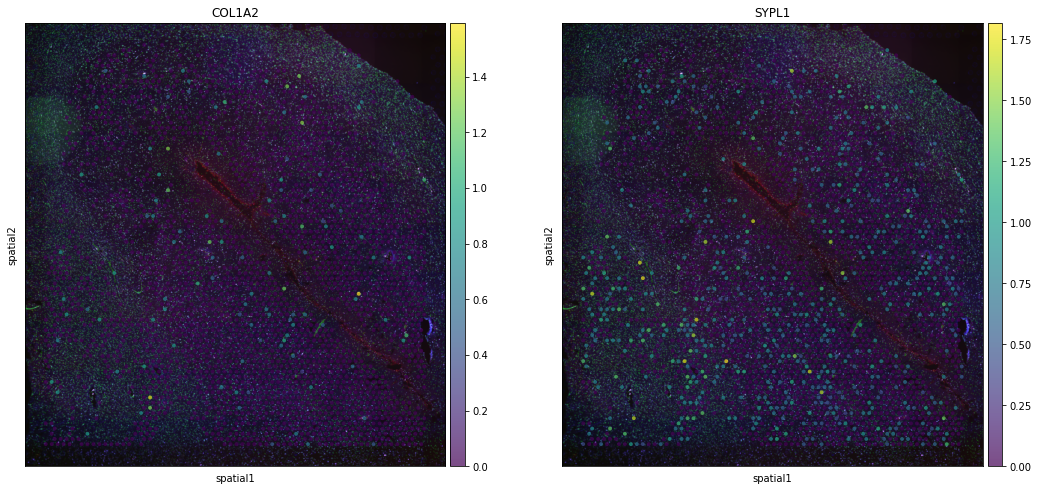

In [32]:
sc.pl.spatial(adata, img_key="hires", color=["COL1A2", "SYPL1"], alpha=0.7)

### Appendix

Pandas : Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language

Matplotlib : Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python

SCVI: Probabilistic models for single-cell omics data

Scanpy: Scanpy is an open sourcy library for analyzing single-cell gene expression data built jointly with anndata in python

Anndata: Python package for handling annotated data matrices in memory and on disk, positioned between pandas and xarray

